<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [5]:
df=pd.read_excel("BG_Dataset/BG_Sample55.xlsx")

In [6]:
# Colab
#df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample3.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [7]:
df.shape

(1968, 14)

In [8]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1988-09-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,400.0,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,60.0,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,긴급하게 낮음,NaN,NaN,Android,55.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [10]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [11]:
df['Event'].value_counts()

EGV     1926
교정        16
탄수화물      16
경고         6
이름         1
장치         1
성          1
생년월일       1
Name: Event, dtype: int64

In [12]:
df['Glucose'].value_counts()

168.0    27
170.0    26
207.0    24
202.0    23
159.0    22
         ..
329.0     1
296.0     1
330.0     1
302.0     1
400.0     1
Name: Glucose, Length: 259, dtype: int64

In [13]:
df.tail()

,Timestamp,Event,Glucose,Insulin,Meal
1963,2021-01-18T07:46:23,EGV,238.0,NaN,NaN
1964,2021-01-18T07:51:22,EGV,240.0,NaN,NaN
1965,2021-01-18T07:56:23,EGV,244.0,NaN,NaN
1966,2021-01-18T08:01:23,EGV,250.0,NaN,NaN
1967,2021-01-18T08:06:23,EGV,257.0,NaN,NaN


In [14]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [15]:
# 식사 횟수
df['Meal'].value_counts()

0.0    16
Name: Meal, dtype: int64

In [16]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,NaN,이름,NaN,NaN,NaN
1,NaN,성,NaN,NaN,NaN
2,NaN,생년월일,NaN,NaN,NaN
3,NaN,장치,NaN,NaN,NaN
4,NaN,경고,NaN,NaN,NaN
5,NaN,경고,400.0,NaN,NaN
6,NaN,경고,60.0,NaN,NaN
7,NaN,경고,NaN,NaN,NaN
8,NaN,경고,NaN,NaN,NaN
9,NaN,경고,55.0,NaN,NaN


In [17]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [18]:
df.head(20)

,Timestamp,Event,Glucose,Insulin,Meal
10,2021-01-11T15:36:39,교정,204.0,NaN,NaN
11,2021-01-11T15:41:28,교정,177.0,NaN,NaN
12,2021-01-11T15:41:42,EGV,181.0,NaN,NaN
13,2021-01-11T15:46:33,EGV,181.0,NaN,NaN
14,2021-01-11T15:51:34,EGV,180.0,NaN,NaN
15,2021-01-11T15:56:34,EGV,181.0,NaN,NaN
16,2021-01-11T16:01:33,EGV,174.0,NaN,NaN
17,2021-01-11T16:06:34,EGV,170.0,NaN,NaN
18,2021-01-11T16:11:34,EGV,169.0,NaN,NaN
19,2021-01-11T16:16:34,EGV,165.0,NaN,NaN


In [19]:
df.shape

(1958, 5)

In [20]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [21]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,2021-01-11T15:36:39,교정,204.0,NaN,NaN
1,2021-01-11T15:41:28,교정,177.0,NaN,NaN
2,2021-01-11T15:41:42,EGV,181.0,NaN,NaN
3,2021-01-11T15:46:33,EGV,181.0,NaN,NaN
4,2021-01-11T15:51:34,EGV,180.0,NaN,NaN
5,2021-01-11T15:56:34,EGV,181.0,NaN,NaN
6,2021-01-11T16:01:33,EGV,174.0,NaN,NaN
7,2021-01-11T16:06:34,EGV,170.0,NaN,NaN
8,2021-01-11T16:11:34,EGV,169.0,NaN,NaN
9,2021-01-11T16:16:34,EGV,165.0,NaN,NaN


In [22]:
df.shape

(1958, 5)

In [23]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [24]:
def isNaN(num):
    return num==num

In [25]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [26]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [27]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [28]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [29]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [30]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [31]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [32]:
glucose_count_high(df,'Glucose')

높음 :  0


In [33]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [34]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [35]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [36]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [37]:
low_list

[]

In [38]:
calibration_count_low(df,'Event')

교정 :  16


In [39]:
calib_list

[0,
 1,
 162,
 359,
 454,
 650,
 746,
 944,
 1042,
 1044,
 1235,
 1343,
 1535,
 1627,
 1823,
 1915]

In [40]:
insul_count(df,'Insulin')

인슐린 :  0


In [41]:
insulin_list

[]

In [42]:
meal_count(df,'Meal')

식사 횟수 :  16


In [43]:
meal_list

[23,
 197,
 255,
 323,
 483,
 608,
 781,
 843,
 911,
 1193,
 1365,
 1425,
 1490,
 1653,
 1780,
 1949]

In [44]:
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [45]:
df['Meal'].value_counts()

0.0    16
Name: Meal, dtype: int64

In [46]:
isNaN(df['Glucose'][14])

True

In [47]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [48]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [49]:
import math
math.isnan(df['Glucose'][14])

False

In [50]:
insulin_list

[]

In [51]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [52]:
insulin_list

[323,
 197,
 843,
 781,
 911,
 1425,
 1490,
 1365,
 23,
 1949,
 608,
 483,
 1193,
 1780,
 1653,
 255]

In [53]:
df=df.drop(insulin_list)

In [54]:
df[10:20]

,Timestamp,Event,Glucose,Insulin,Meal
10,2021-01-11T16:21:34,EGV,167.0,NaN,NaN
11,2021-01-11T16:26:34,EGV,170.0,NaN,NaN
12,2021-01-11T16:31:34,EGV,175.0,NaN,NaN
13,2021-01-11T16:36:35,EGV,168.0,NaN,NaN
14,2021-01-11T16:41:34,EGV,171.0,NaN,NaN
15,2021-01-11T16:46:34,EGV,170.0,NaN,NaN
16,2021-01-11T16:51:35,EGV,171.0,NaN,NaN
17,2021-01-11T16:56:33,EGV,174.0,NaN,NaN
18,2021-01-11T17:01:34,EGV,181.0,NaN,NaN
19,2021-01-11T17:06:34,EGV,182.0,NaN,NaN


In [55]:
df['Glucose'].unique()

array([204., 177., 181., 180., 174., 170., 169., 165., 167., 175., 168.,
       171., 182., 179., 166., 172., 197., 203., 198., 194., 189., 184.,
       185., 163., 164., 176., 188., 190., 207., 216., 219., 221., 217.,
       215., 212., 199., 195., 193., 178., 202., 224., 233., 240., 247.,
       258., 263., 273., 285., 293., 294., 290., 283., 271., 249., 230.,
       201., 159., 153., 147., 141., 135., 131., 127., 124., 119., 116.,
       113., 108., 107., 105., 104., 103., 102., 101., 100.,  99.,  97.,
        96., 106., 109., 111., 115., 118., 121., 126., 128., 133., 137.,
       139., 140., 138., 143., 145., 148., 151., 152., 156., 160., 191.,
       200., 206., 209., 211., 214., 213., 210., 223., 222., 208., 186.,
       183., 158., 134., 132., 129., 125., 122., 114., 112., 110.,  98.,
        95.,  93.,  90.,  86.,  89.,  94., 120., 144., 123., 117., 142.,
       136., 146., 149., 196., 173., 155., 150., 161., 205., 218., 220.,
       192., 225., 228., 226., 227., 231., 229., 16

In [56]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1942
Meal         1926
dtype: int64

In [57]:
df['Event'].value_counts()

EGV    1926
교정       16
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [58]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [59]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [60]:
fix_glucose_low(df,'Glucose')

In [61]:
fix_glucose(df,'Glucose')

In [62]:
df['Glucose'].value_counts()

168.0    27
170.0    26
207.0    24
202.0    23
159.0    22
         ..
339.0     1
296.0     1
341.0     1
319.0     1
304.0     1
Name: Glucose, Length: 256, dtype: int64

In [63]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1942
Meal         1926
dtype: int64

In [64]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [65]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [66]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [67]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [68]:
new_meal_list

[23,
 196,
 253,
 320,
 479,
 603,
 775,
 836,
 903,
 1184,
 1355,
 1414,
 1478,
 1640,
 1766,
 1934]

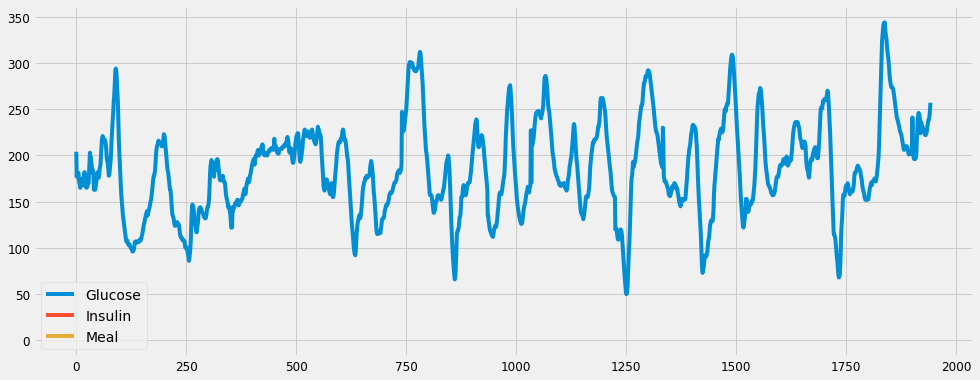

In [69]:
df.plot(figsize=(15,6))
plt.show()

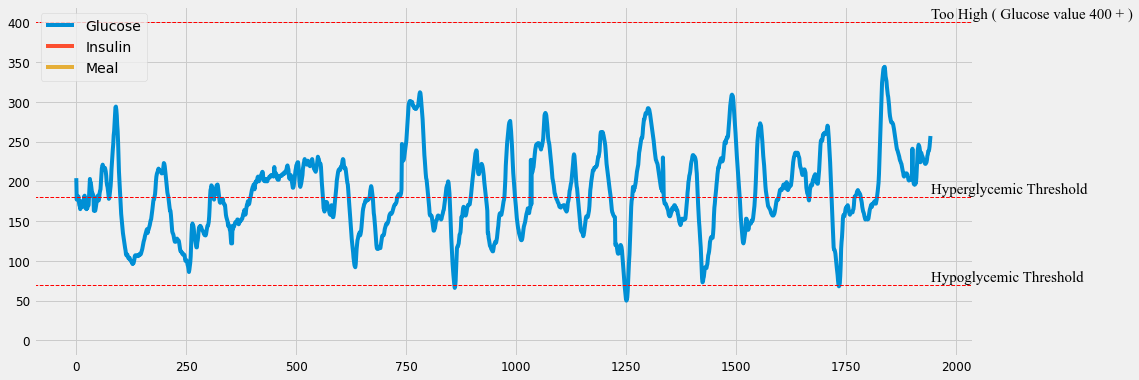

In [70]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [71]:
#df.drop(0,inplace=True)

In [72]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [73]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [74]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [75]:
#interpolate_glucose(df,'Glucose')

In [76]:
#meal

In [77]:
#insul

In [78]:
df['Glucose'].isnull().sum()

0

In [79]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [80]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [81]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [82]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

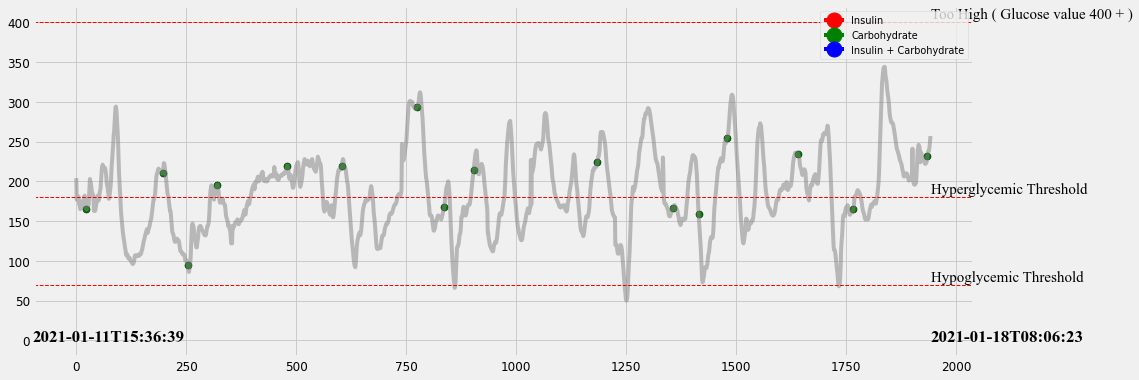

In [83]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [84]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [85]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [86]:
df[1900:1950]

,Timestamp,Event,Glucose,Insulin,Meal
1900,2021-01-18T04:44:52,교정,241.0,0.0,0.0
1901,2021-01-18T04:46:25,EGV,205.0,0.0,0.0
1902,2021-01-18T04:51:25,EGV,201.0,0.0,0.0
1903,2021-01-18T04:56:29,EGV,197.0,0.0,0.0
1904,2021-01-18T05:01:23,EGV,196.0,0.0,0.0
1905,2021-01-18T05:06:24,EGV,198.0,0.0,0.0
1906,2021-01-18T05:11:25,EGV,196.0,0.0,0.0
1907,2021-01-18T05:16:23,EGV,198.0,0.0,0.0
1908,2021-01-18T05:21:24,EGV,198.0,0.0,0.0
1909,2021-01-18T05:26:24,EGV,205.0,0.0,0.0


In [87]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [88]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [89]:
import numpy as np
import tensorflow as tf
import random as rn

In [90]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [91]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [92]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [93]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [94]:
leaky_relu = tf.nn.leaky_relu

## 15분

In [95]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [96]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [97]:
len(raw_seq) * 0.7

1359.3999999999999

In [98]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [99]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [100]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [101]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [102]:
y_val_uni.shape

(575,)

In [103]:
y_train_uni.shape

(1353,)

In [104]:
#y_train_uni_origin[:10]

In [105]:
#y_train_uni.shape
df[:15]

,Timestamp,Event,Glucose,Insulin,Meal
0,2021-01-11T15:36:39,교정,204.0,0.0,0.0
1,2021-01-11T15:41:28,교정,177.0,0.0,0.0
2,2021-01-11T15:41:42,EGV,181.0,0.0,0.0
3,2021-01-11T15:46:33,EGV,181.0,0.0,0.0
4,2021-01-11T15:51:34,EGV,180.0,0.0,0.0
5,2021-01-11T15:56:34,EGV,181.0,0.0,0.0
6,2021-01-11T16:01:33,EGV,174.0,0.0,0.0
7,2021-01-11T16:06:34,EGV,170.0,0.0,0.0
8,2021-01-11T16:11:34,EGV,169.0,0.0,0.0
9,2021-01-11T16:16:34,EGV,165.0,0.0,0.0


In [106]:
x_train_uni[5:10]

array([[[181],
        [174],
        [170],
        [169],
        [165],
        [167]],

       [[174],
        [170],
        [169],
        [165],
        [167],
        [170]],

       [[170],
        [169],
        [165],
        [167],
        [170],
        [175]],

       [[169],
        [165],
        [167],
        [170],
        [175],
        [168]],

       [[165],
        [167],
        [170],
        [175],
        [168],
        [171]]], dtype=int64)

In [107]:
y_train_uni[5:10]

array([168, 171, 170, 171, 174], dtype=int64)

In [108]:
#df['Glucose'].head(10)

In [109]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [110]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [111]:
from keras.layers import SimpleRNN

In [112]:
#n_steps = 3
#delay=3
#n_features=1

In [113]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [114]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False)) #recurrent_dropout=0.2
model.add(Dense(1))

In [115]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [116]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  10.42402047189851


#### Validation

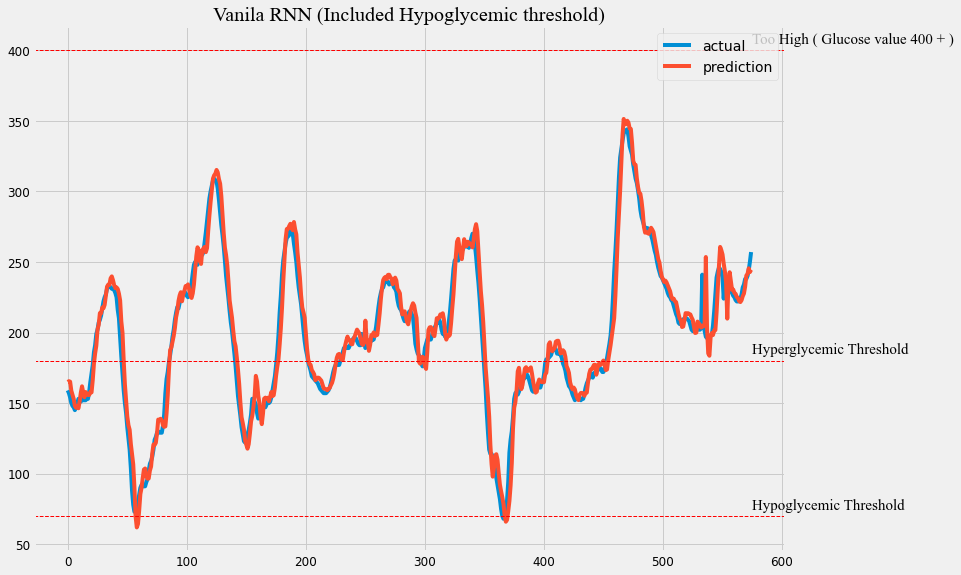

In [117]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [118]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

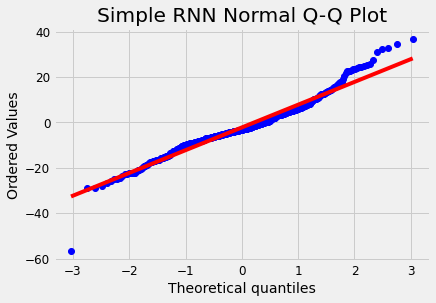

In [119]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

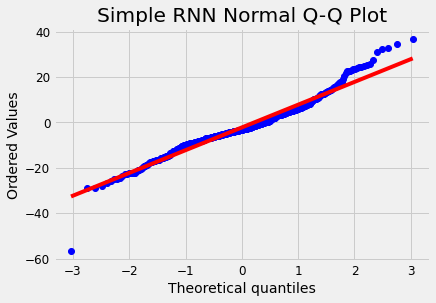

In [120]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [121]:
residuals=DataFrame(residuals)

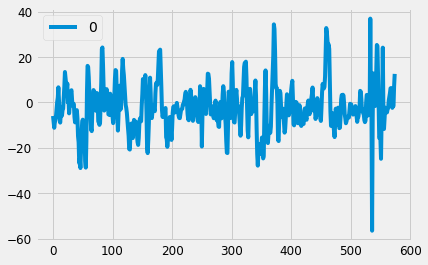

In [122]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002780320E100>]],
      dtype=object)

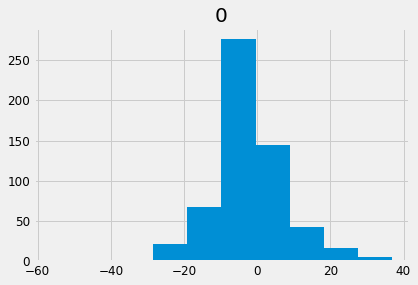

In [123]:

residuals.hist()

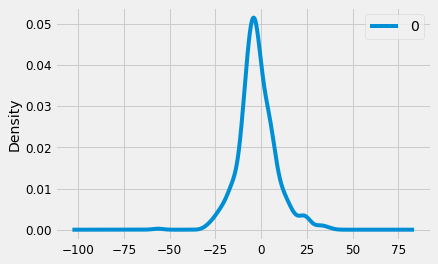

In [124]:
residuals.plot(kind='kde')

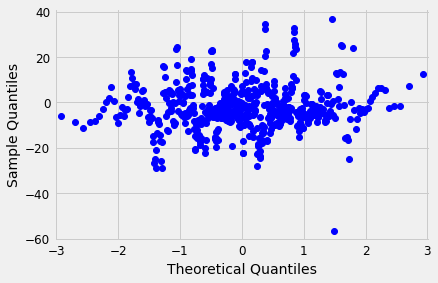

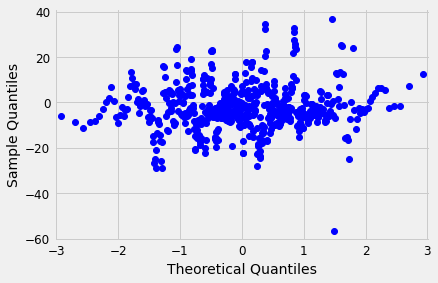

In [125]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [126]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  10.663310101129591


#### Train

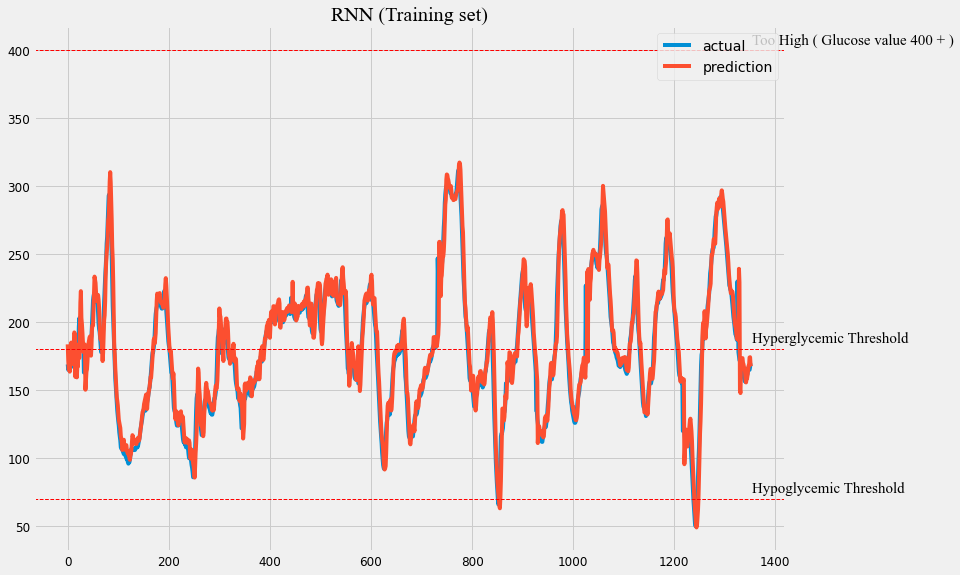

In [127]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

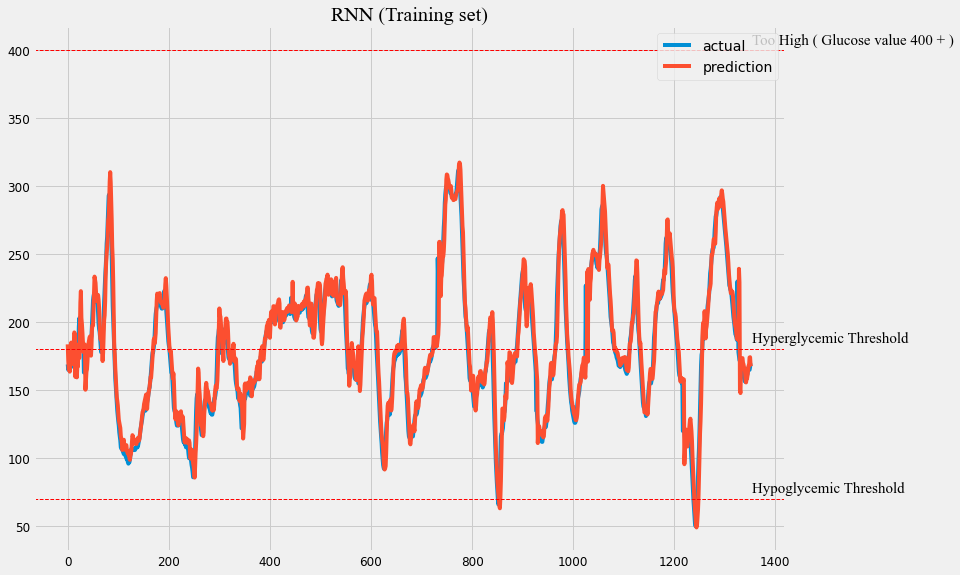

In [128]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [129]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [130]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:],unit_forget_bias=False)) #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=500,verbose=0)
K.clear_session()
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

In [ ]:
TRAIN_SPLIT

#### 잔차

In [ ]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [ ]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400

In [ ]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400

In [ ]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400

In [ ]:
#predict_result

In [ ]:
#predict_result

In [ ]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [ ]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [ ]:
#residuals.plot(kind='kde')

In [ ]:
#residuals.plot()

In [ ]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [ ]:
pip install geneticalgorithm2

In [ ]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [ ]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [ ]:
#val_rnn_15_predict_result[:5]

In [ ]:
#ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [ ]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [ ]:
# Baseline
#test_result = RMSE(y_val_uni_origin,ex)
#test_result

In [ ]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
#test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [ ]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [ ]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 30 - np.sqrt(mean_squared_error(val_rnn_15_predict_result * X[0] + val_lstm_15_predict_result * X[1] +val_slstm_15_predict_result * X[2] + 
                                val_bilstm_15_predict_result * X[3] + val_gru_15_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [ ]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [ ]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [ ]:
model1 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [ ]:
model1.run()

In [ ]:
# RMSE 
optimized = val_rnn_15_predict_result * model1.output_dict['variable'][0] + val_lstm_15_predict_result *model1.output_dict['variable'][1] + val_slstm_15_predict_result * model1.output_dict['variable'][2] + val_bilstm_15_predict_result * model1.output_dict['variable'][3] + val_gru_15_predict_result * model1.output_dict['variable'][4]
optimized_rmse_15 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_15

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 30분

In [ ]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [ ]:
y_val_uni.shape


In [ ]:

x_val_uni.shape

In [ ]:
x_train_uni[0]

In [ ]:
df['Glucose'].head(15)

In [ ]:
y_train_uni[0]

### RNN - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [ ]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [ ]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:],unit_forget_bias=False))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
#model.Flatten()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [ ]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2))
#model.add(GRU(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

#### Train

### GA

In [ ]:
#ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [ ]:
#ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [ ]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

In [ ]:
#test_result =  mean_squared_error(y_val_uni_origin,ex)
#test_result

In [ ]:
#test_result * 2 - (1000 + test_result)

In [ ]:
#result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [ ]:
#mean_squared_error

In [ ]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [ ]:
#def evaluate2(X):
#  pen = 0 
  #coef = [0,0,0,0,0]
#  result =0
  #result2 = 0
  #print(X)
#  if sum(X) > 0.99 and sum(X) < 1:
#    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
 #   abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
  #  result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
   # print("\n ** B ** \n")
    #print(X)
    #print()
    #print("\n ** C ** \n")
    #print(result)
  #return np.sum(X) + pen
    #count += 1 
  #return -result
    
    

In [ ]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 50 - np.sqrt(mean_squared_error(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + 
                                val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [ ]:
#abc.shape

In [ ]:
#y_val_uni_origin.shape

In [ ]:
#val_rnn_30_predict_result.shape

In [ ]:
#abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [ ]:
#get = mean_squared_error(y_val_uni_origin,abc)

In [ ]:
#test_result*2 - mean_squared_error(y_val_uni_origin,abc)

In [ ]:
#varbound = np.array([[500,5000]]*5)

In [ ]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [ ]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [ ]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [ ]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [ ]:
model2.run()

In [ ]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
optimized_rmse_30 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_30

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [ ]:
model2.output_dict

In [ ]:
#model2.output_dict['variable'][0]


In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [ ]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [ ]:
x_train_uni[0]

In [ ]:
y_train_uni[0]

In [ ]:
df['Glucose'].head(20)

### RNN - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2)) # recurrent_dropout=0.2
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()

In [ ]:
val_rnn_60_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2))  #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_lstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2)) # recurrent_dropout=0.2
model.add(LSTM(50,activation='relu',recurrent_dropout=0.2,unit_forget_bias=False))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [ ]:
val_slstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
from tensorflow.keras import layers
model = Sequential()

model.add(Bidirectional(LSTM(50,activation='relu',return_sequences=True,recurrent_dropout=0.2),input_shape=x_train_uni.shape[-2:]))
model.add(Bidirectional(layers.LSTM(50,activation='relu',recurrent_dropout=0.2,unit_forget_bias=False)))
#model.add(Bidirectional(forward_layer,backward_layer=backward_layer,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_bilstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
predict_result.shape

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [ ]:
val_gru_60_predict_result = model.predict(x_val_uni,verbose=0)
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 60min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

#### 잔차

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

#### Train

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GA

In [ ]:
val_rnn_60_predict_result = np.asarray(val_rnn_60_predict_result)
val_lstm_60_predict_result = np.asarray(val_lstm_60_predict_result)
val_slstm_60_predict_result = np.asarray(val_slstm_60_predict_result)
val_bilstm_60_predict_result = np.asarray(val_bilstm_60_predict_result)
val_gru_60_predict_result = np.asarray(val_gru_60_predict_result)

In [ ]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 100 - np.sqrt(mean_squared_error(val_rnn_60_predict_result * X[0] + val_lstm_60_predict_result * X[1] +val_slstm_60_predict_result * X[2] + 
                                val_bilstm_60_predict_result * X[3] + val_gru_60_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [ ]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [ ]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [ ]:
model3 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [ ]:
model3.run()

In [ ]:
# RMSE 
optimized = val_rnn_60_predict_result * model3.output_dict['variable'][0] + val_lstm_60_predict_result *model3.output_dict['variable'][1] + val_slstm_60_predict_result * model3.output_dict['variable'][2] + val_bilstm_60_predict_result * model3.output_dict['variable'][3] + val_gru_60_predict_result * model3.output_dict['variable'][4]
optimized_rmse_60 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_60

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [ ]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15,optimized_rmse_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30,optimized_rmse_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60,optimized_rmse_60]


In [ ]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]
val_optimized_result = [optimized_rmse_15,optimized_rmse_30,optimized_rmse_60]

In [ ]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [ ]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result,]

In [ ]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result,val_optimized_result]

In [ ]:
val_result_list

In [ ]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU','Optimized'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

In [ ]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

## CNN LSTM